In [63]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [64]:

# List physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("🚀 GPU(s) detected!")
    for gpu in gpus:
        print(f" - {gpu}")
    print("TensorFlow will use the GPU by default when available.")
else:
    print("⚠️ No GPU detected. Using CPU only.")

🚀 GPU(s) detected!
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow will use the GPU by default when available.


In [65]:
IMG_SIZE = 32
BATCH_SIZE = 64
BUFFER_SIZE = 10000

def preprocess(image, label):
    # Crop to center square (CelebA is 178x218, crop to 140x140)
    image = tf.image.crop_to_bounding_box(image, 40, 15, 140, 140)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Scale to [-1, 1]
    return image

# Download CelebA
dataset = tfds.load('celeb_a', split='train', shuffle_files=True)
dataset = dataset.map(lambda x: preprocess(x['image'], x['attributes']))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


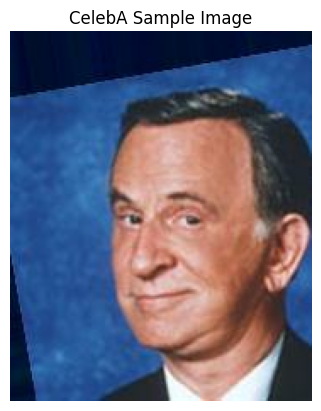

In [66]:
ds = tfds.load('celeb_a', split='train', shuffle_files=True)
for sample in ds.take(1):
    img = sample['image']
    plt.imshow(img)
    plt.axis('off')
    plt.title('CelebA Sample Image')
    plt.show()

In [67]:
# Generator
def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(4*4*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((4, 4, 256)),
        tf.keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32, 32, 3]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()


In [68]:
generator.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 4096)           │       409,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 8, 8, 256)      │     1,638,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 32, 32, 3)      │         9,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,894,720 (11.04 MB)

 Trainable params: 2,885,760 (11.01 MB)

 Non-trainable params: 8,960 (35.00 KB)

In [69]:
discriminator.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,985 (851.50 KB)

 Trainable params: 217,985 (851.50 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.0, beta_2=0.9)


In [71]:
EPOCHS = 25
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

gen_losses = []
disc_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss  # Return losses

def train(dataset, epochs):
    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.append(gen_loss.numpy())
            epoch_disc_loss.append(disc_loss.numpy())
        # Store average loss for this epoch
        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))
        generate_and_show_images(generator, epoch+1, seed)

def generate_and_show_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

E0000 00:00:1749785683.062314   14421 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


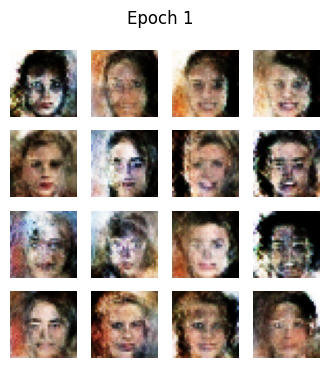

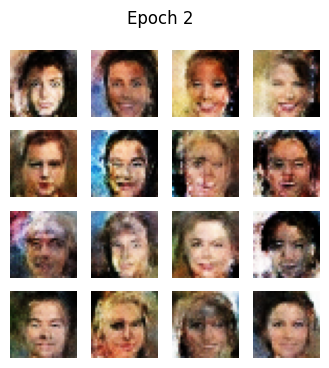

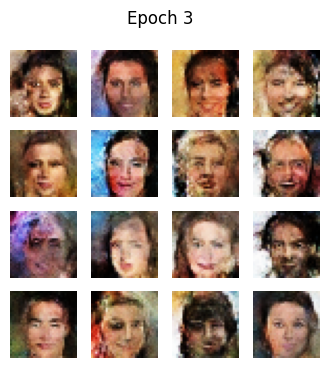

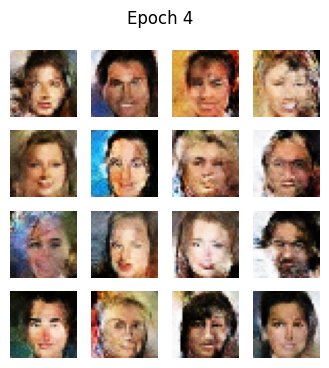

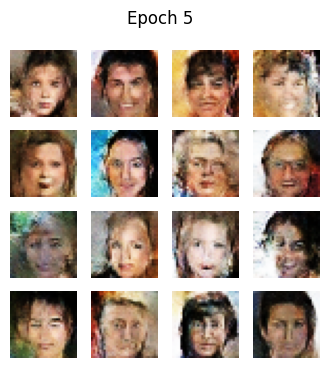

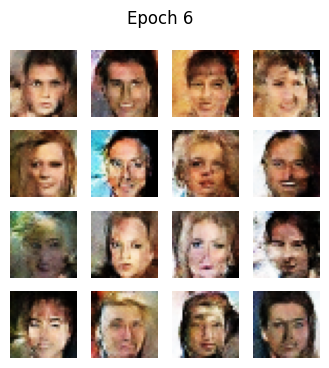

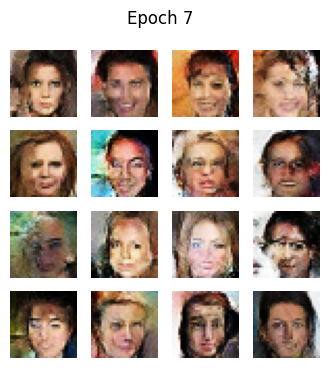

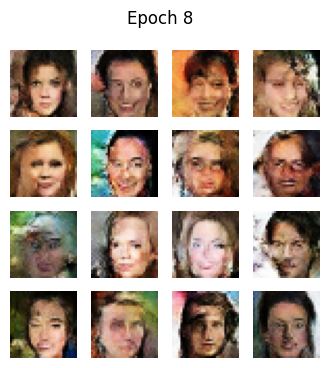

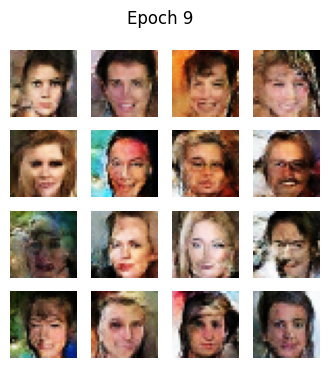

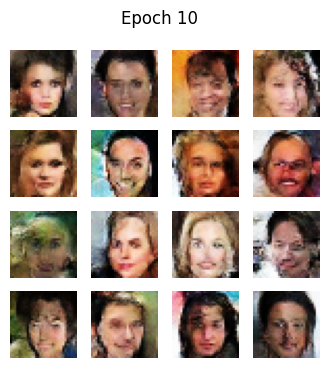

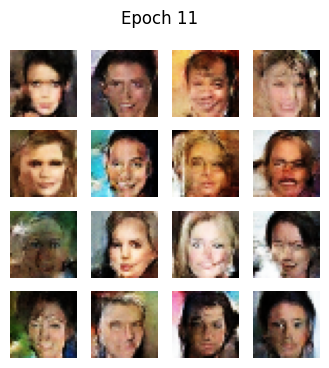

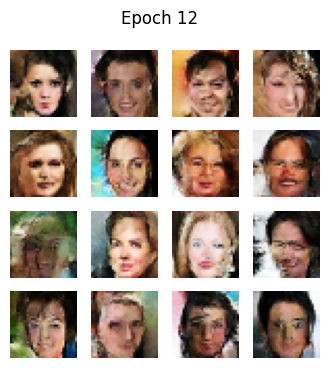

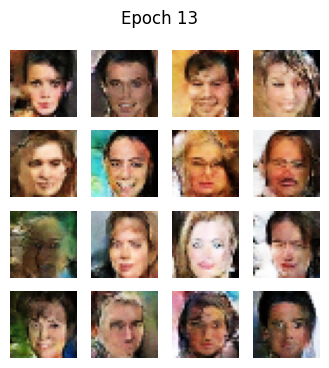

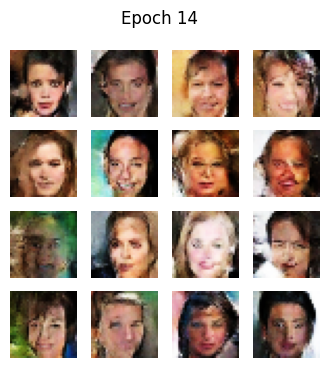

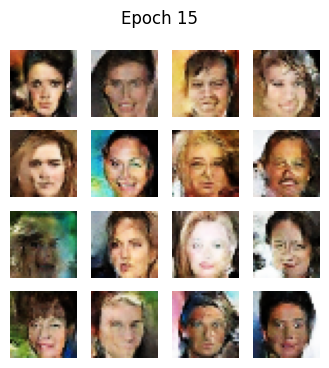

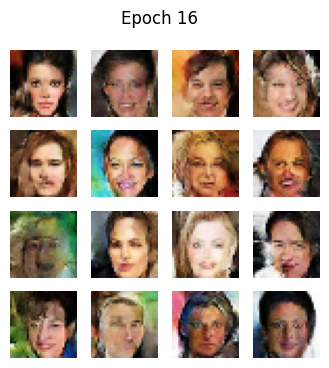

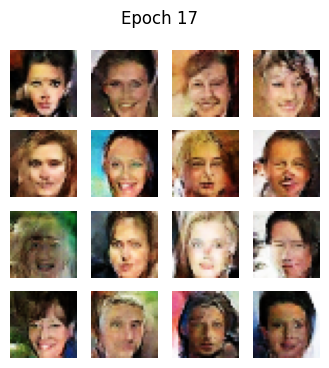

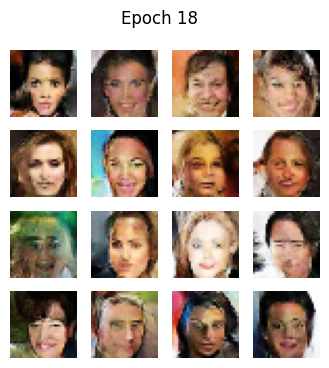

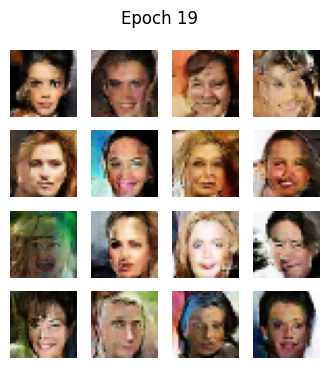

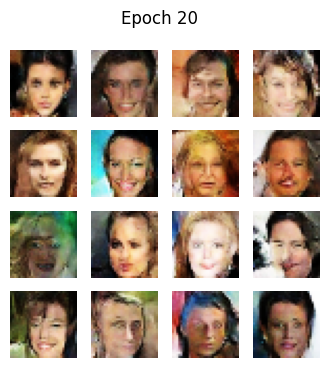

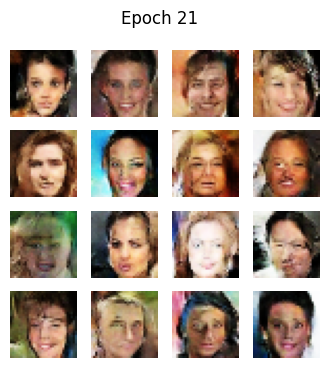

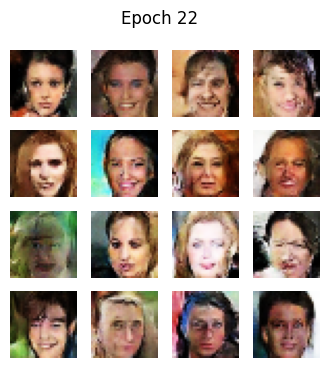

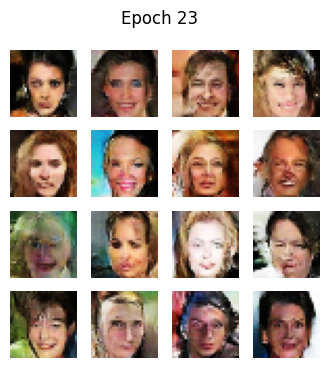

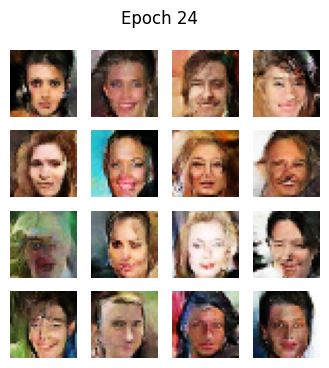

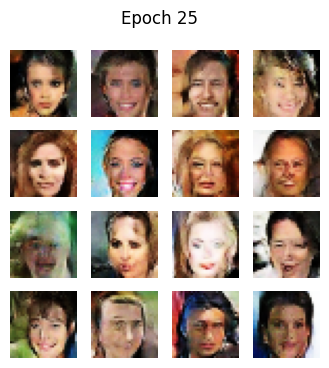

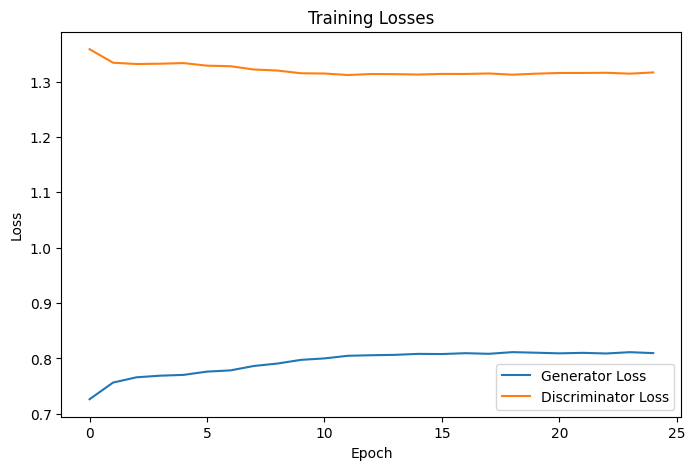

In [73]:
train(dataset, EPOCHS)

# After training, plot the losses
plt.figure(figsize=(8,5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

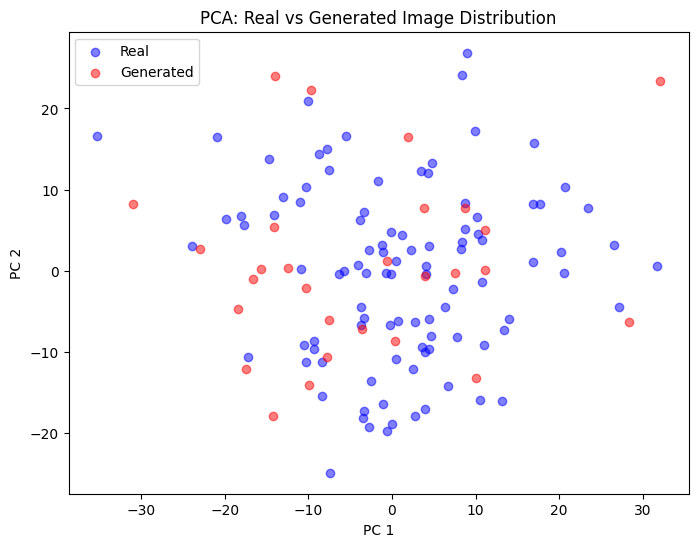

In [74]:
from sklearn.decomposition import PCA

# Get a batch of real images (first 64 images from your dataset)
real_images = next(iter(dataset))
if isinstance(real_images, tuple):  # If dataset returns (image, label)
    real_images = real_images[0]
real_images = real_images[:BATCH_SIZE].numpy().reshape(BATCH_SIZE, -1)  # Flatten

# Generate a batch of fake images
noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
generated_images = generator(noise, training=False).numpy().reshape(BATCH_SIZE, -1)

# Use PCA to reduce to 2D
pca = PCA(n_components=2)
all_images = np.concatenate([real_images, generated_images], axis=0)
pca_result = pca.fit_transform(all_images)
real_pca = pca_result[:100]
gen_pca = pca_result[100:]

plt.figure(figsize=(8,6))
plt.scatter(real_pca[:,0], real_pca[:,1], alpha=0.5, label='Real', c='blue')
plt.scatter(gen_pca[:,0], gen_pca[:,1], alpha=0.5, label='Generated', c='red')
plt.legend()
plt.title('PCA: Real vs Generated Image Distribution')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Conclusion

After training a DCGAN on the CelebA dataset for 25 epochs, the PCA plot of real versus generated images reveals a promising overlap in the principal component space, suggesting the generator has learned important data characteristics. The training loss curves are stable, with the discriminator loss remaining high and flat, and the generator loss gradually increasing before stabilizing, indicating a slow but steady adversarial process. The absence of mode collapse or instability reflects robust training, though the generator may be limited by the discriminator’s strength or architectural constraints. To further enhance image realism and model convergence, integrating spectral normalization, regularization strategies, and exploring advanced loss functions such as the hinge loss are recommended. Overall, the results demonstrate a stable GAN training regime, with clear opportunities for refinement to achieve even closer alignment with real data distributions.
